In [1]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# ============================
# Utilitários de Plot
# ============================

def plot_scene(traj_planned: np.ndarray,
               traj_executed: np.ndarray,
               goal: Tuple[float, float],
               title: str = "RHC - Planejamento x Execução") -> None:
    """Plota a trajetória planejada vs. executada e o alvo."""
    fig, ax = plt.subplots(figsize=(6, 6))

    # Região convexa (quatro faces): desenhando como polígono convexo aproximado
    # As faces originais:
    #  x - 9y <= -8
    # -9x +  y <= -8
    #  x + 7y <= 72
    # 7x +  y <= 72
    # Aqui apenas marco um retângulo de visualização; as faces estão no modelo.
    ax.set_xlim(-1, 9)
    ax.set_ylim(-1, 9)
    ax.grid(True, alpha=0.4, linewidth=0.5)

    if traj_planned.size > 0:
        ax.plot(traj_planned[:, 0], traj_planned[:, 1], "-o", label="Planejada")

    if traj_executed.size > 0:
        ax.plot(traj_executed[:, 0], traj_executed[:, 1], "-^", label="Executada")

    ax.plot(goal[0], goal[1], "r*", markersize=14, label="Goal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()


# ============================
# Modelo (um passo de horizonte finito)
# ============================

def solve_step_lp_conv_bounded(
    times: List[str],
    origin: Tuple[float, float],
    goal: Tuple[float, float],
    vel0: Tuple[float, float],
    deltaT: float,
    mass: float
) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Resolve um subproblema de horizonte curto (ex.: 2 instantes ["0","1"]).
    Dinâmica:
        x_{k+1} = x_k + vx_k*dt + 0.5*dt^2 * Fx_k/m
        y_{k+1} = y_k + vy_k*dt + 0.5*dt^2 * Fy_k/m
        vx_{k+1} = vx_k + dt * Fx_k/m
        vy_{k+1} = vy_k + dt * Fy_k/m

    Região convexo-limitada via 4 desigualdades lineares.
    Objetivo (QP): dist^2 até o goal no instante final + ||v_T||^2 + pequena penal de esforço.

    Retorna:
        (obj_value, X[Tx2], V[Tx2], F[Tx2], XY_final)
    """
    xO, yO = origin
    xG, yG = goal
    vxO, vyO = vel0

    assert len(times) >= 2, "Use ao menos dois instantes (ex.: ['0','1'])."
    nWP = len(times) - 1  # ultimo indice de transição

    mdl = Model("LPConvBounded_RHC")
    mdl.setParam("OutputFlag", 0)   # silencioso

    # Variáveis
    x = mdl.addVars(times, name="x", lb=-GRB.INFINITY)
    y = mdl.addVars(times, name="y", lb=-GRB.INFINITY)
    vx = mdl.addVars(times, name="vx", lb=-2, ub=2)  # limites de velocidade (ajustáveis)
    vy = mdl.addVars(times, name="vy", lb=-2, ub=2)
    Fx = mdl.addVars(times, name="Fx", lb=-2, ub=2)  # limites de "força/acel" (ajustáveis)
    Fy = mdl.addVars(times, name="Fy", lb=-2, ub=2)

    # Condições iniciais
    t0 = times[0]
    mdl.addConstr(x[t0] == xO, name="x0")
    mdl.addConstr(y[t0] == yO, name="y0")
    mdl.addConstr(vx[t0] == vxO, name="vx0")
    mdl.addConstr(vy[t0] == vyO, name="vy0")

    # Dinâmica (para t = 0..nWP-1)
    for k in range(nWP):
        tk = times[k]
        tk1 = times[k + 1]

        mdl.addConstr(
            x[tk1] == x[tk] + vx[tk] * deltaT + 0.5 * (deltaT**2) * Fx[tk] / mass,
            name=f"xpos_{k}"
        )
        mdl.addConstr(
            y[tk1] == y[tk] + vy[tk] * deltaT + 0.5 * (deltaT**2) * Fy[tk] / mass,
            name=f"ypos_{k}"
        )
        mdl.addConstr(
            vx[tk1] == vx[tk] + deltaT * Fx[tk] / mass,
            name=f"vx_{k}"
        )
        mdl.addConstr(
            vy[tk1] == vy[tk] + deltaT * Fy[tk] / mass,
            name=f"vy_{k}"
        )

    # Região factível (quatro semiespaços), para todos os instantes
    for t in times:
        mdl.addConstr(x[t] - 9 * y[t] <= -8, name=f"face1_{t}")
        mdl.addConstr(-9 * x[t] + y[t] <= -8, name=f"face2_{t}")
        mdl.addConstr(x[t] + 7 * y[t] <= 72, name=f"face3_{t}")
        mdl.addConstr(7 * x[t] + y[t] <= 72, name=f"face4_{t}")

    # Objetivo (QP) no instante final
    tF = times[-1]
    # Erro de posição final
    err_x = x[tF] - xG
    err_y = y[tF] - yG
    # Penalizações
    w_goal = 1.0
    w_v    = 0.1
    w_u    = 0.01

    mdl.setObjective(
        w_goal * (err_x * err_x + err_y * err_y)
        + w_v * (vx[tF] * vx[tF] + vy[tF] * vy[tF])
        + w_u * quicksum(Fx[t] * Fx[t] + Fy[t] * Fy[t] for t in times),
        sense=GRB.MINIMIZE
    )

    mdl.optimize()

    if mdl.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Modelo não encontrou solução ótima. Status={mdl.Status}")

    # Extrai solução
    X = np.array([[x[t].X, y[t].X] for t in times], dtype=float)
    V = np.array([[vx[t].X, vy[t].X] for t in times], dtype=float)
    F = np.array([[Fx[t].X, Fy[t].X] for t in times], dtype=float)

    obj_value = float(mdl.ObjVal)
    return obj_value, X, V, F, X[-1]  # última posição

Restricted license - for non-production use only - expires 2026-11-23
Iterações: 8
Posição final executada: (6.136, 8.205)


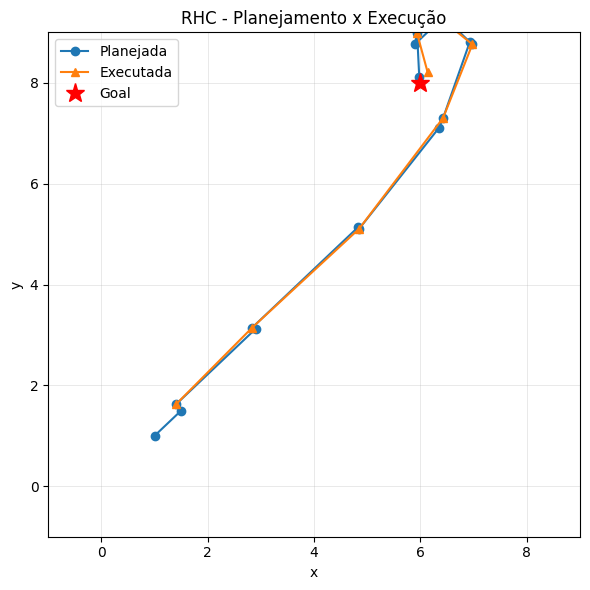

In [2]:
# Horizonte curto de 1 passo (duas amostras: 0 -> 1)
times = ["0", "1"]

# Parâmetros do modelo
deltaT = 1.0
mass   = 2.0

# Estado inicial e alvo
inicioCoord = (1.0, 1.0)
inicioVel   = (0.0, 0.0)
goal        = (6.0, 8.0)

# Parâmetros do RHC/execução
desvio_ruido = 0.1  # ruido (execução)
tol_goal     = 0.5   # tolerância de chegada
max_iters    = 150

# Trajetórias agregadas
traj_planned = []
traj_exec    = []

# Estado "real" (executado) começa no início
xr, yr = inicioCoord
vxr, vyr = inicioVel

for k in range(max_iters):
    # O RHC "vê" o estado atual real como origem do próximo passo
    origin = (xr, yr)
    vel0   = (vxr, vyr)

    obj, Xplan, Vplan, Fplan, xfinal = solve_step_lp_conv_bounded(
        times=times,
        origin=origin,
        goal=goal,
        vel0=vel0,
        deltaT=deltaT,
        mass=mass
    )

    # Guardar trajetória planejada do passo (opcional: só o primeiro ponto)
    traj_planned.extend(Xplan.tolist())

    # "Executa" apenas o primeiro controle e evolui 1 passo (closed-loop):
    # x_{1|k} = Xplan[1]
    # Vamos simular ruído na execução
    xr = Xplan[1, 0] + np.random.normal(0.0, desvio_ruido)
    yr = Xplan[1, 1] + np.random.normal(0.0, desvio_ruido)
    vxr = Vplan[1, 0]
    vyr = Vplan[1, 1]

    traj_exec.append([xr, yr])

    # Critério de parada: perto do objetivo
    if np.hypot(xr - goal[0], yr - goal[1]) <= tol_goal:
        break

traj_planned = np.array(traj_planned, dtype=float)
traj_exec    = np.array(traj_exec, dtype=float)

print(f"Iterações: {len(traj_exec)}")
print(f"Posição final executada: ({traj_exec[-1,0]:.3f}, {traj_exec[-1,1]:.3f})")
plot_scene(traj_planned, traj_exec, goal, title="RHC - Planejamento x Execução")


In [3]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# ============================
# Geometria de polígonos
# ============================

def polygon_HG(vertices: List[Tuple[float, float]]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Recebe vértices CCW de um polígono convexo e devolve:
        H: (m,2) com normais unitárias h_i apontando para FORA
        G: (m,) com g_i tal que a fronteira é h_i^T x = g_i
    """
    V = np.asarray(vertices, dtype=float)
    m = len(V)
    H, G = [], []
    for i in range(m):
        p = V[i]
        q = V[(i + 1) % m]
        e = q - p
        nvec = np.array([e[1], -e[0]], dtype=float)  # +90° (fora para CCW)
        nrm = np.linalg.norm(nvec)
        if nrm < 1e-12:
            raise ValueError("Aresta degenerada no polígono.")
        h = nvec / nrm
        g = float(h @ p)
        H.append(h)
        G.append(g)
    return np.array(H), np.array(G)


# ============================
# Plot util
# ============================

def plot_scene(traj_planned: np.ndarray,
               traj_executed: np.ndarray,
               goal: Tuple[float, float],
               obstacles: List[List[Tuple[float, float]]] | None = None,
               title: str = "RHC - Planejamento x Execução") -> None:
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    ax.set_xlim(-1, 9)
    ax.set_ylim(-1, 9)
    ax.grid(True, alpha=0.4, linewidth=0.5)

    # Desenha obstáculos
    if obstacles:
        for poly in obstacles:
            P = np.array(poly + [poly[0]], dtype=float)
            ax.fill(P[:, 0], P[:, 1], alpha=0.25, color="tab:red", edgecolor="k", linewidth=1.2)

    if traj_planned.size > 0:
        ax.plot(traj_planned[:, 0], traj_planned[:, 1], "-o", label="Planejada")

    if traj_executed.size > 0:
        ax.plot(traj_executed[:, 0], traj_executed[:, 1], "-^", label="Executada")

    ax.plot(goal[0], goal[1], "r*", markersize=14, label="Goal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()


# ============================
# Modelo (um passo de horizonte finito) com obstáculos
# ============================

def solve_step_miqp_with_obstacles(
    times: List[str],
    origin: Tuple[float, float],
    goal: Tuple[float, float],
    vel0: Tuple[float, float],
    deltaT: float,
    mass: float,
    obstacles: List[List[Tuple[float, float]]],
    bigM: float = 1e3,
    eps_obs: float = 1e-3,
) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    MIQP para um passo de RHC (times p.ex. ["0", "1"]) com:
      - dinâmica discreta 2D (pos, vel, força)
      - região convexa global (exemplo de 4 semiespaços)
      - obstáculos convexos CCW via disjunção (big-M)

    Retorna:
        (obj_value, X[Tx2], V[Tx2], F[Tx2], X_final)
    """
    xO, yO = origin
    xG, yG = goal
    vxO, vyO = vel0
    assert len(times) >= 2
    nWP = len(times) - 1

    mdl = Model("RHC_MIQP_Obstacles")
    mdl.setParam("OutputFlag", 0)

    # Variáveis contínuas
    x = mdl.addVars(times, name="x", lb=-GRB.INFINITY)
    y = mdl.addVars(times, name="y", lb=-GRB.INFINITY)
    vx = mdl.addVars(times, name="vx", lb=-2, ub=2)
    vy = mdl.addVars(times, name="vy", lb=-2, ub=2)
    Fx = mdl.addVars(times, name="Fx", lb=-2, ub=2)
    Fy = mdl.addVars(times, name="Fy", lb=-2, ub=2)

    # Condições iniciais
    t0 = times[0]
    mdl.addConstr(x[t0] == xO, name="x0")
    mdl.addConstr(y[t0] == yO, name="y0")
    mdl.addConstr(vx[t0] == vxO, name="vx0")
    mdl.addConstr(vy[t0] == vyO, name="vy0")

    # Dinâmica
    for k in range(nWP):
        tk, tk1 = times[k], times[k + 1]
        mdl.addConstr(x[tk1] == x[tk] + vx[tk]*deltaT + 0.5*(deltaT**2)*Fx[tk]/mass, name=f"xpos_{k}")
        mdl.addConstr(y[tk1] == y[tk] + vy[tk]*deltaT + 0.5*(deltaT**2)*Fy[tk]/mass, name=f"ypos_{k}")
        mdl.addConstr(vx[tk1] == vx[tk] + deltaT*Fx[tk]/mass, name=f"vx_{k}")
        mdl.addConstr(vy[tk1] == vy[tk] + deltaT*Fy[tk]/mass, name=f"vy_{k}")

    # Região convexa global (exemplo de 4 semiespaços)
    #  x - 9y <= -8
    # -9x +  y <= -8
    #  x + 7y <= 72
    # 7x +  y <= 72
    for t in times:
        mdl.addConstr(x[t] - 9*y[t] <= -8, name=f"face1_{t}")
        mdl.addConstr(-9*x[t] + y[t] <= -8, name=f"face2_{t}")
        mdl.addConstr(x[t] + 7*y[t] <= 72, name=f"face3_{t}")
        mdl.addConstr(7*x[t] + y[t] <= 72, name=f"face4_{t}")

    # Obstáculos convexos
    # Fora do obstáculo k em cada tempo t:
    #    existe i tal que  h_{k,i}^T [x_t;y_t] >= g_{k,i} + eps_obs
    # Modelagem:
    #    h_{k,i}^T [x_t;y_t] >= g_{k,i} + eps_obs - M*(1 - z_{t,k,i})
    #    sum_i z_{t,k,i} >= 1
    Z = {}  # binárias
    HG = []
    for k, poly in enumerate(obstacles):
        Hk, Gk = polygon_HG(poly)
        HG.append((Hk, Gk))
        m_k = Hk.shape[0]
        for t in times:
            for i in range(m_k):
                Z[(t, k, i)] = mdl.addVar(vtype=GRB.BINARY, name=f"z_t{t}_k{k}_i{i}")

    mdl.update()

    for k, (Hk, Gk) in enumerate(HG):
        m_k = Hk.shape[0]
        for t in times:
            # Pelo menos uma aresta "violada" (fora)
            mdl.addConstr(quicksum(Z[(t, k, i)] for i in range(m_k)) >= 1, name=f"obs_any_{t}_k{k}")
            # Restrições big-M para cada i
            for i in range(m_k):
                a, b = Hk[i]
                g = float(Gk[i])
                mdl.addConstr(
                    a * x[t] + b * y[t] >= g + eps_obs - bigM * (1 - Z[(t, k, i)]),
                    name=f"obs_sep_{t}_k{k}_i{i}"
                )

    # Objetivo (QP)
    tF = times[-1]
    err_x = x[tF] - goal[0]
    err_y = y[tF] - goal[1]
    w_goal, w_v, w_u = 1.0, 0.1, 0.01

    mdl.setObjective(
        w_goal * (err_x * err_x + err_y * err_y)
        + w_v * (vx[tF] * vx[tF] + vy[tF] * vy[tF])
        + w_u * quicksum(Fx[t] * Fx[t] + Fy[t] * Fy[t] for t in times),
        sense=GRB.MINIMIZE
    )

    mdl.optimize()
    if mdl.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Modelo não encontrou solução ótima. Status={mdl.Status}")

    X = np.array([[x[t].X, y[t].X] for t in times], dtype=float)
    V = np.array([[vx[t].X, vy[t].X] for t in times], dtype=float)
    F = np.array([[Fx[t].X, Fy[t].X] for t in times], dtype=float)
    return float(mdl.ObjVal), X, V, F, X[-1]

Iterações: 15
Final exec: (8.163, 3.670)


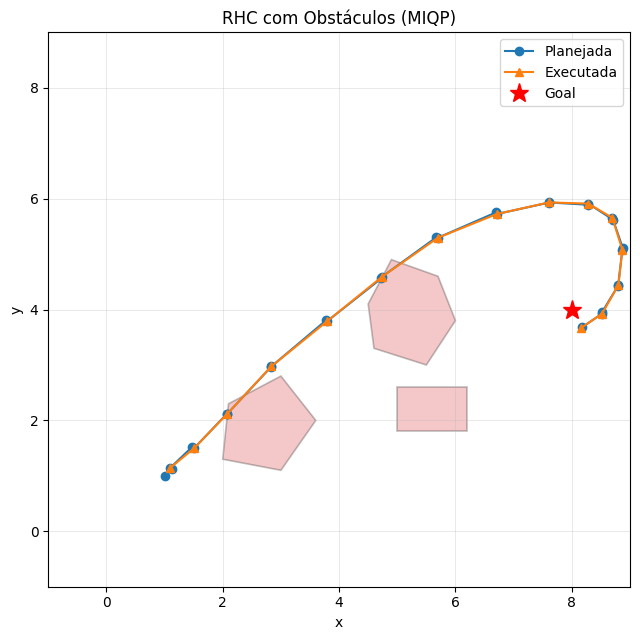

In [4]:
# ============================
# Execução (RHC) com obstáculos
# ============================

# Horizonte curto (aplica primeiro controle e realimenta)
times = ["0", "1"]

deltaT = 0.5
mass   = 2.0

inicioCoord = (1.0, 1.0)
inicioVel   = (0.0, 0.0)
goal        = (8.0, 4.0)

# Obstáculos (exemplos convexos CCW)
obstacles: List[List[Tuple[float, float]]] = [
    # Um pentágono perto do canto inferior
    [(2.0, 1.3), (3.0, 1.1), (3.6, 2.0), (3.0, 2.8), (2.1, 2.3)],
    # Um hexágono na região central-superior
    [(4.6, 3.3), (5.5, 3.0), (6.0, 3.8), (5.7, 4.6), (4.9, 4.9), (4.5, 4.1)],
    # Um retângulo simples (CCW)
    [(5.0, 1.8), (6.2, 1.8), (6.2, 2.6), (5.0, 2.6)],
]

desvio_ruido = 0.02
tol_goal     = 0.5
max_iters    = 200

traj_planned = []
traj_exec    = []

xr, yr = inicioCoord
vxr, vyr = inicioVel

for k in range(max_iters):
    try:
        obj, Xplan, Vplan, Fplan, xfinal = solve_step_miqp_with_obstacles(
            times=times,
            origin=(xr, yr),
            goal=goal,
            vel0=(vxr, vyr),
            deltaT=deltaT,
            mass=mass,
            obstacles=obstacles,
            bigM=2e3,      # pode ajustar conforme a escala geométrica
            eps_obs=5e-3,  # "folga" para afastar da fronteira
        )
    except RuntimeError as e:
        print("Falha no MIQP:", e)
        break

    traj_planned.extend(Xplan.tolist())

    # Executa 1 passo com ruído
    xr = Xplan[1, 0] + np.random.normal(0.0, desvio_ruido)
    yr = Xplan[1, 1] + np.random.normal(0.0, desvio_ruido)
    vxr = Vplan[1, 0]
    vyr = Vplan[1, 1]
    traj_exec.append([xr, yr])

    if np.hypot(xr - goal[0], yr - goal[1]) <= tol_goal:
        break

traj_planned = np.array(traj_planned, dtype=float)
traj_exec    = np.array(traj_exec, dtype=float)

print(f"Iterações: {len(traj_exec)}")
if len(traj_exec) > 0:
    print(f"Final exec: ({traj_exec[-1,0]:.3f}, {traj_exec[-1,1]:.3f})")
plot_scene(traj_planned, traj_exec, goal, obstacles, title="RHC com Obstáculos (MIQP)")

In [9]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# ============================
# Geometria de polígonos
# ============================

def polygon_HG(vertices: List[Tuple[float, float]]) -> Tuple[np.ndarray, np.ndarray]:
    V = np.asarray(vertices, dtype=float)
    m = len(V)
    H, G = [], []
    for i in range(m):
        p = V[i]; q = V[(i + 1) % m]
        e = q - p
        nvec = np.array([e[1], -e[0]], dtype=float)  # normal para fora (CCW)
        nrm = np.linalg.norm(nvec)
        if nrm < 1e-12:
            raise ValueError("Aresta degenerada no polígono.")
        h = nvec / nrm
        g = float(h @ p)
        H.append(h); G.append(g)
    return np.array(H), np.array(G)

# ============================
# Plot util
# ============================

def plot_scene(traj_planned: np.ndarray,
               traj_executed: np.ndarray,
               goal: Tuple[float, float],
               obstacles: List[List[Tuple[float, float]]] | None = None,
               title: str = "RHC - Planejamento x Execução") -> None:
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    ax.set_xlim(-1, 9); ax.set_ylim(-1, 9)
    ax.grid(True, alpha=0.4, linewidth=0.5)
    if obstacles:
        for poly in obstacles:
            P = np.array(poly + [poly[0]], dtype=float)
            ax.fill(P[:, 0], P[:, 1], alpha=0.25, color="tab:red", edgecolor="k", linewidth=1.2)
    if traj_planned.size > 0:
        ax.plot(traj_planned[:, 0], traj_planned[:, 1], "-o", label="Planejada")
    if traj_executed.size > 0:
        ax.plot(traj_executed[:, 0], traj_executed[:, 1], "-^", label="Executada")
    ax.plot(goal[0], goal[1], "r*", markersize=14, label="Goal")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_title(title)
    ax.legend(loc="best"); plt.tight_layout(); plt.show()

# ============================
# Passo MIQP com obstáculos (segmento seguro)
# ============================

def solve_step_miqp_segment_safe(
    times: List[str],
    origin: Tuple[float, float],
    goal: Tuple[float, float],
    vel0: Tuple[float, float],
    deltaT: float,
    mass: float,
    obstacles: List[List[Tuple[float, float]]],
    bigM: float = 2e3,
    eps_obs: float = 5e-3,
) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    MIQP para 1 passo de RHC (times p.ex. ["0","1"]) com:
      - dinâmica 2D
      - região convexa global (4 semiespaços de exemplo)
      - obstáculos convexos: garantia de que CADA SEGMENTO [x_t, x_{t+1}] NÃO INTERSECTA o obstáculo,
        impondo que ambas as pontas fiquem do mesmo lado externo de ALGUMA face do obstáculo.
    """
    xO, yO = origin; vxO, vyO = vel0
    assert len(times) >= 2
    nWP = len(times) - 1

    mdl = Model("RHC_MIQP_SegmentSafe")
    mdl.setParam("OutputFlag", 0)

    # Variáveis
    x  = mdl.addVars(times, name="x",  lb=-GRB.INFINITY)
    y  = mdl.addVars(times, name="y",  lb=-GRB.INFINITY)
    vx = mdl.addVars(times, name="vx", lb=-2, ub=2)
    vy = mdl.addVars(times, name="vy", lb=-2, ub=2)
    Fx = mdl.addVars(times, name="Fx", lb=-2, ub=2)
    Fy = mdl.addVars(times, name="Fy", lb=-2, ub=2)

    # Condições iniciais
    t0 = times[0]
    mdl.addConstr(x[t0] == xO, name="x0")
    mdl.addConstr(y[t0] == yO, name="y0")
    mdl.addConstr(vx[t0] == vxO, name="vx0")
    mdl.addConstr(vy[t0] == vyO, name="vy0")

    # Dinâmica
    for k in range(nWP):
        tk, tk1 = times[k], times[k + 1]
        mdl.addConstr(x[tk1] == x[tk] + vx[tk]*deltaT + 0.5*(deltaT**2)*Fx[tk]/mass, name=f"xpos_{k}")
        mdl.addConstr(y[tk1] == y[tk] + vy[tk]*deltaT + 0.5*(deltaT**2)*Fy[tk]/mass, name=f"ypos_{k}")
        mdl.addConstr(vx[tk1] == vx[tk] + deltaT*Fx[tk]/mass, name=f"vx_{k}")
        mdl.addConstr(vy[tk1] == vy[tk] + deltaT*Fy[tk]/mass, name=f"vy_{k}")

    # Região convexa global (quatro semiespaços do seu exemplo)
    for t in times:
        mdl.addConstr(x[t] - 9*y[t] <= -8, name=f"face1_{t}")
        mdl.addConstr(-9*x[t] + y[t] <= -8, name=f"face2_{t}")
        mdl.addConstr(x[t] + 7*y[t] <= 72, name=f"face3_{t}")
        mdl.addConstr(7*x[t] + y[t] <= 72, name=f"face4_{t}")

    # Obstáculos convexos — SEGMENTO SEGURO
    # Para cada obstáculo k e cada segmento t->t+1:
    #  existe uma face i tal que:
    #     h_i^T [x_t;y_t] >= g_i + eps
    #     h_i^T [x_{t+1};y_{t+1}] >= g_i + eps
    #  Modelado com binária zseg[t,k,i] e somatório >= 1.
    HG = []
    for poly in obstacles:
        HG.append(polygon_HG(poly))

    zseg = {}  # binárias por segmento
    for k, (Hk, Gk) in enumerate(HG):
        m_k = Hk.shape[0]
        for s in range(nWP):           # segmentos
            t, t1 = times[s], times[s+1]
            for i in range(m_k):
                zseg[(s, k, i)] = mdl.addVar(vtype=GRB.BINARY, name=f"zseg_s{s}_k{k}_i{i}")
            # Ao menos uma face separa o segmento inteiro
            mdl.addConstr(quicksum(zseg[(s, k, i)] for i in range(m_k)) >= 1, name=f"seg_any_s{s}_k{k}")
            # Desigualdades com big-M para as duas pontas do segmento
            for i in range(m_k):
                a, b = Hk[i]; g = float(Gk[i])
                mdl.addConstr(a * x[t]  + b * y[t]  >= g + eps_obs - bigM * (1 - zseg[(s, k, i)]),
                              name=f"seg_sep_start_s{s}_k{k}_i{i}")
                mdl.addConstr(a * x[t1] + b * y[t1] >= g + eps_obs - bigM * (1 - zseg[(s, k, i)]),
                              name=f"seg_sep_end_s{s}_k{k}_i{i}")

    # Objetivo (QP)
    tF = times[-1]
    err_x = x[tF] - goal[0]
    err_y = y[tF] - goal[1]
    w_goal, w_v, w_u = 1.0, 0.1, 0.01
    mdl.setObjective(
        w_goal * (err_x * err_x + err_y * err_y)
        + w_v * (vx[tF] * vx[tF] + vy[tF] * vy[tF])
        + w_u * quicksum(Fx[t]*Fx[t] + Fy[t]*Fy[t] for t in times),
        sense=GRB.MINIMIZE
    )

    mdl.optimize()
    if mdl.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Modelo não encontrou solução ótima. Status={mdl.Status}")

    X = np.array([[x[t].X,  y[t].X]  for t in times], dtype=float)
    V = np.array([[vx[t].X, vy[t].X] for t in times], dtype=float)
    F = np.array([[Fx[t].X, Fy[t].X] for t in times], dtype=float)
    return float(mdl.ObjVal), X, V, F, X[-1]

Iterações: 5
Final exec: (6.359, 4.480)


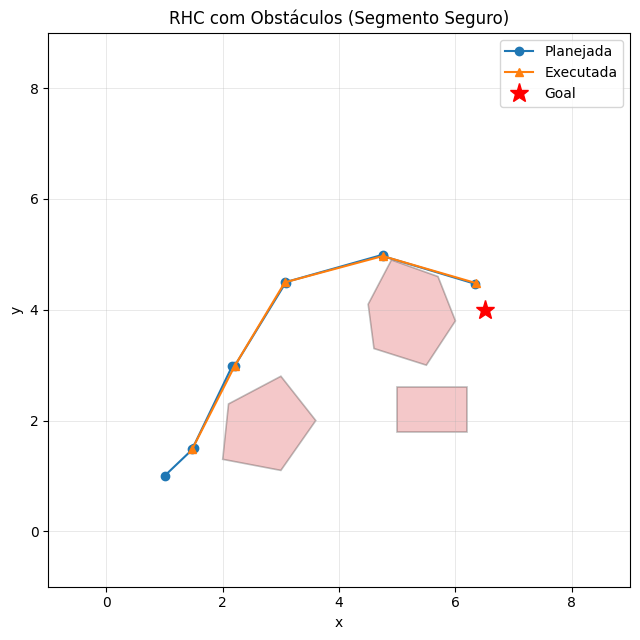

In [10]:
times  = ["0", "1"]
deltaT = 1.0; 
mass = 2.0
inicioCoord = (1.0, 1.0); 
inicioVel = (0.0, 0.0)
goal = (6.5, 4.0)

obstacles: List[List[Tuple[float, float]]] = [
    [(2.0, 1.3), (3.0, 1.1), (3.6, 2.0), (3.0, 2.8), (2.1, 2.3)],
    [(4.6, 3.3), (5.5, 3.0), (6.0, 3.8), (5.7, 4.6), (4.9, 4.9), (4.5, 4.1)],
    [(5.0, 1.8), (6.2, 1.8), (6.2, 2.6), (5.0, 2.6)],
]

desvio_ruido = 0.02
tol_goal, max_iters = 0.5, 250

traj_planned, traj_exec = [], []
xr, yr = inicioCoord; vxr, vyr = inicioVel

for k in range(max_iters):
    try:
        obj, Xplan, Vplan, Fplan, xfinal = solve_step_miqp_segment_safe(
            times=times,
            origin=(xr, yr),
            goal=goal,
            vel0=(vxr, vyr),
            deltaT=deltaT,
            mass=mass,
            obstacles=obstacles,
            bigM=2e3,
            eps_obs=5e-3,
        )
    except RuntimeError as e:
        print("Falha no MIQP:", e); break

    traj_planned.extend(Xplan.tolist())

    # aplica controle do 1º passo e realimenta (com ruído)
    xr = Xplan[1, 0] + np.random.normal(0.0, desvio_ruido)
    yr = Xplan[1, 1] + np.random.normal(0.0, desvio_ruido)
    vxr = Vplan[1, 0]; vyr = Vplan[1, 1]
    traj_exec.append([xr, yr])

    if np.hypot(xr - goal[0], yr - goal[1]) <= tol_goal:
        break

traj_planned = np.array(traj_planned, dtype=float)
traj_exec    = np.array(traj_exec, dtype=float)
print(f"Iterações: {len(traj_exec)}")
if len(traj_exec) > 0:
    print(f"Final exec: ({traj_exec[-1,0]:.3f}, {traj_exec[-1,1]:.3f})")
plot_scene(traj_planned, traj_exec, goal, obstacles, title="RHC com Obstáculos (Segmento Seguro)")